In [1]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

In [2]:
from imgaug.augmentables.kps import KeypointsOnImage
from imgaug.augmentables.kps import Keypoint
import imgaug.augmenters as iaa

In [3]:
from PIL import Image
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import json
import os

In [4]:
IMG_DIR = './'
JSON = 'animal.json'
KEYPOINT_DEF = pd.read_csv('keypoint_def.csv')

In [5]:
with open(JSON) as infile:
    json_dict = json.load(infile)

In [6]:
colours = KEYPOINT_DEF["Hex colour"].values.tolist()
colours = ["#" + colour for colour in colours]
labels = KEYPOINT_DEF["Name"].values.tolist()

In [7]:
def get_dog(name):
    data = json_dict[name]
    img_data = plt.imread(os.path.join(IMG_DIR, data["img_path"]))
    # If the image is RGBA convert it to RGB.
    if img_data.shape[-1] == 4:
        img_data = img_data.astype(np.uint8)
        img_data = Image.fromarray(img_data)
        img_data = np.array(img_data.convert("RGB"))
    data["img_data"] = img_data

    return data

In [8]:
def visualize_keypoints(images, keypoints):
    fig, axes = plt.subplots(nrows=len(images), ncols=2, figsize=(16, 12))
    [ax.axis("off") for ax in np.ravel(axes)]

    for (ax_orig, ax_all), image, current_keypoint in zip(axes, images, keypoints):
        ax_orig.imshow(image)
        ax_all.imshow(image)

        # If the keypoints were formed by `imgaug` then the coordinates need
        # to be iterated differently.
        if isinstance(current_keypoint, KeypointsOnImage):
            for idx, kp in enumerate(current_keypoint.keypoints):
                ax_all.scatter(
                    [kp.x], [kp.y], c=colours[idx], marker="x", s=50, linewidths=5
                )
        else:
            current_keypoint = np.array(current_keypoint)
            # Since the last entry is the visibility flag, we discard it.
            current_keypoint = current_keypoint[:, :2]
            for idx, (x, y) in enumerate(current_keypoint):
                ax_all.scatter([x], [y], c=colours[idx], marker="x", s=50, linewidths=5)

    plt.tight_layout(pad=2.0)
    plt.show()

In [9]:
samples = list(json_dict.keys())
num_samples = 4
selected_samples = np.random.choice(samples, num_samples, replace=False)

images, keypoints = [], []

In [10]:
for sample in selected_samples:
    data = get_dog(sample)
    image = data["img_data"]
    keypoint = data["joints"]
    images.append(image)
    keypoints.append(keypoint)

In [11]:
IMG_SIZE = 224
BATCH_SIZE = 6
EPOCHS = 50
NUM_KEYPOINTS = 20 * 2

In [12]:
class KeyPointsDataset(keras.utils.Sequence):
    def __init__(self, image_keys, aug, batch_size=BATCH_SIZE, train=True):
        self.image_keys = image_keys
        self.aug = aug
        self.batch_size = batch_size
        self.train = train
        self.on_epoch_end()

    def __len__(self):
        return len(self.image_keys) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_keys))
        if self.train:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        image_keys_temp = [self.image_keys[k] for k in indexes]
        (images, keypoints) = self.__data_generation(image_keys_temp)

        return (images, keypoints)

    def __data_generation(self, image_keys_temp):
        batch_images = np.empty((self.batch_size, IMG_SIZE, IMG_SIZE, 3), dtype="int")
        batch_keypoints = np.empty(
            (self.batch_size, 1, 1, NUM_KEYPOINTS), dtype="float32"
        )

        for i, key in enumerate(image_keys_temp):
            data = get_dog(key)
            current_keypoint = np.array(data["joints"])[:, :2]
            kps = []

            # To apply our data augmentation pipeline, we first need to
            # form Keypoint objects with the original coordinates.
            for j in range(0, len(current_keypoint)):
                kps.append(Keypoint(x=current_keypoint[j][0], y=current_keypoint[j][1]))

            # We then project the original image and its keypoint coordinates.
            current_image = data["img_data"]
            kps_obj = KeypointsOnImage(kps, shape=current_image.shape)

            # Apply the augmentation pipeline.
            (new_image, new_kps_obj) = self.aug(image=current_image, keypoints=kps_obj)
            batch_images[i,] = new_image

            # Parse the coordinates from the new keypoint object.
            kp_temp = []
            for keypoint in new_kps_obj:
                kp_temp.append(np.nan_to_num(keypoint.x))
                kp_temp.append(np.nan_to_num(keypoint.y))

            # More on why this reshaping later.
            batch_keypoints[i,] = np.array(kp_temp).reshape(1, 1, 20 * 2)

        # Scale the coordinates to [0, 1] range.
        batch_keypoints = batch_keypoints / IMG_SIZE

        return (batch_images, batch_keypoints)

In [13]:
train_aug = iaa.Sequential(
    [
        iaa.Resize(IMG_SIZE, interpolation="linear"),
        iaa.Fliplr(0.3),
        # `Sometimes()` applies a function randomly to the inputs with
        # a given probability (0.3, in this case).
        iaa.Sometimes(0.3, iaa.Affine(rotate=10, scale=(0.5, 0.7))),
    ]
)

test_aug = iaa.Sequential([iaa.Resize(IMG_SIZE, interpolation="linear")])

In [14]:
np.random.shuffle(samples)
train_keys, validation_keys = (
    samples[int(len(samples) * 0.15) :],
    samples[: int(len(samples) * 0.15)],
)

Total batches in training set: 28
Total batches in validation set: 5


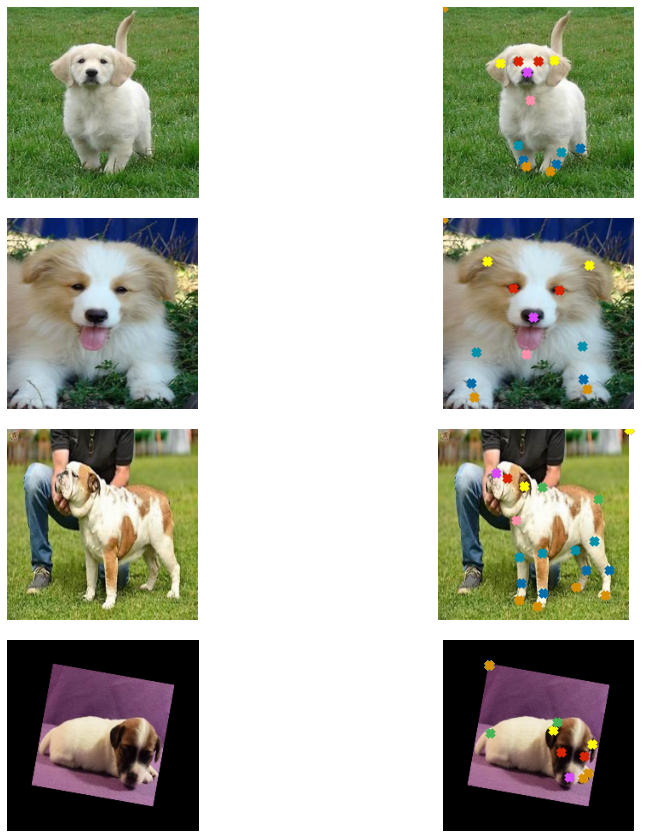

In [15]:
train_dataset = KeyPointsDataset(train_keys, train_aug)
validation_dataset = KeyPointsDataset(validation_keys, test_aug, train=False)

print(f"Total batches in training set: {len(train_dataset)}")
print(f"Total batches in validation set: {len(validation_dataset)}")

sample_images, sample_keypoints = next(iter(train_dataset))
assert sample_keypoints.max() == 1.0
assert sample_keypoints.min() == 0.0

sample_keypoints = sample_keypoints[:4].reshape(-1, 20, 2) * IMG_SIZE
visualize_keypoints(sample_images[:4], sample_keypoints)

In [16]:
def get_model():
    # Load the pre-trained weights of MobileNetV2 and freeze the weights
    backbone = keras.applications.MobileNetV2(
        weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    backbone.trainable = False

    inputs = layers.Input((IMG_SIZE, IMG_SIZE, 3))
    x = keras.applications.mobilenet_v2.preprocess_input(inputs)
    x = backbone(x)
    x = layers.Dropout(0.3)(x)
    x = layers.SeparableConv2D(
        NUM_KEYPOINTS, kernel_size=5, strides=1, activation="relu"
    )(x)
    outputs = layers.SeparableConv2D(
        NUM_KEYPOINTS, kernel_size=3, strides=1, activation="sigmoid"
    )(x)

    return keras.Model(inputs, outputs, name="keypoint_detector")

In [17]:
get_model().summary()

Model: "keypoint_detector"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 dropout (Dropout)           (None, 7, 7, 1280)        0         
                                                 

In [18]:
model = get_model()
model.compile(loss="mse", optimizer=keras.optimizers.Adam(1e-4))
model.fit(train_dataset, validation_data=validation_dataset, epochs=EPOCHS)

Epoch 1/50
28/28 [==============================] - 5s 139ms/step - loss: 0.0920 - val_loss: 0.1238
Epoch 2/50
28/28 [==============================] - 3s 121ms/step - loss: 0.0969 - val_loss: 0.1222
Epoch 3/50
28/28 [==============================] - 3s 123ms/step - loss: 0.0906 - val_loss: 0.1203
Epoch 4/50
28/28 [==============================] - 3s 121ms/step - loss: 0.0896 - val_loss: 0.1174
Epoch 5/50
28/28 [==============================] - 3s 119ms/step - loss: 0.0875 - val_loss: 0.1134
Epoch 6/50
28/28 [==============================] - 3s 119ms/step - loss: 0.0893 - val_loss: 0.1091
Epoch 7/50
28/28 [==============================] - 3s 120ms/step - loss: 0.0803 - val_loss: 0.1050
Epoch 8/50
28/28 [==============================] - 3s 121ms/step - loss: 0.0807 - val_loss: 0.1019
Epoch 9/50
28/28 [==============================] - 3s 120ms/step - loss: 0.0835 - val_loss: 0.0999
Epoch 10/50
28/28 [==============================] - 3s 120ms/step - loss: 0.0811 - val_loss: 0.0975

In [19]:
sample_val_images, sample_val_keypoints = next(iter(validation_dataset))

In [20]:
sample_val_images = sample_val_images[:4]
sample_val_keypoints = sample_val_keypoints[:4].reshape(-1, 20, 2) * IMG_SIZE
predictions = model.predict(sample_val_images).reshape(-1, 20, 2) * IMG_SIZE

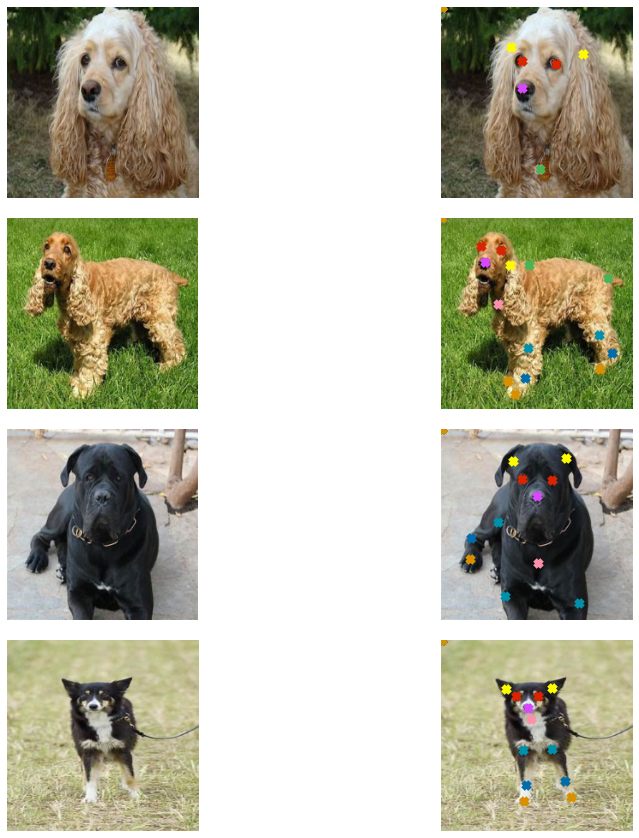

In [21]:
# Ground-truth
visualize_keypoints(sample_val_images, sample_val_keypoints)

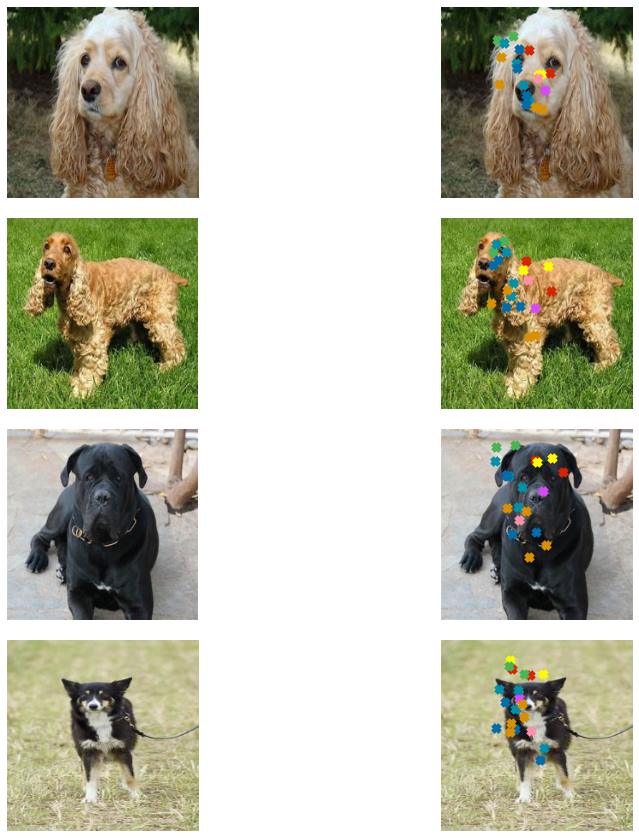

In [22]:
# Predictions
visualize_keypoints(sample_val_images, predictions)

In [23]:
predictions

array([[[127.04161 ,  76.89967 ],
        [102.17744 ,  50.192856],
        [116.69068 ,  78.48681 ],
        [113.0974  ,  79.64457 ],
        [121.07303 ,  96.72565 ],
        [112.860825,  82.79912 ],
        [ 65.37182 ,  38.016235],
        [ 83.23895 ,  33.25297 ],
        [ 95.5464  ,  90.64705 ],
        [102.61345 , 109.52193 ],
        [ 73.507126,  41.738937],
        [ 86.681984,  65.743225],
        [ 98.56418 , 113.07694 ],
        [ 98.405495, 102.43979 ],
        [ 90.298996,  48.693005],
        [ 88.19164 ,  71.80159 ],
        [109.8918  , 117.57132 ],
        [117.59277 , 118.86331 ],
        [ 69.41226 ,  58.35334 ],
        [ 67.50404 ,  89.65421 ]],

       [[128.42046 ,  85.925545],
        [ 99.40434 ,  50.54569 ],
        [124.77937 ,  55.769005],
        [ 94.89702 ,  60.731777],
        [109.6757  , 104.847176],
        [100.91662 ,  72.9556  ],
        [ 59.978195,  39.669106],
        [ 73.00334 ,  26.7557  ],
        [ 83.1662  ,  75.77753 ],
        [ 81